In [2]:
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2

print("PyTorch:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)


PyTorch: 2.8.0+cu126
Running on: cuda


In [4]:
import kagglehub

path = kagglehub.dataset_download("aneeshdighe/corals-classification")
print("Dataset downloaded to:", path)
!ls "$path"

Using Colab cache for faster access to the 'corals-classification' dataset.
Dataset downloaded to: /kaggle/input/corals-classification
'Bleached Corals and Healthy Corals Classification'


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.sharedMLP = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=False)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.sharedMLP(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.sharedMLP(self.max_pool(x).view(x.size(0), -1))
        out = avg_out + max_out
        return self.sigmoid(out).unsqueeze(2).unsqueeze(3)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv1(x_cat))



In [6]:
class BasicBlockCBAM(nn.Module):
    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.ca = ChannelAttention(planes)
        self.sa = SpatialAttention()
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.ca(out) * out
        out = self.sa(out) * out
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)


class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Replace layer 4 with CBAM blocks
        self.backbone.layer4 = nn.Sequential(
            BasicBlockCBAM(256, 512, stride=2, downsample=nn.Sequential(
                nn.Conv2d(256, 512, 1, stride=2, bias=False),
                nn.BatchNorm2d(512)
            )),
            BasicBlockCBAM(512, 512)
        )

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)


In [7]:
def apply_clahe(pil_img):
    img = np.array(pil_img)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    img_clahe = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return Image.fromarray(img_clahe)

train_transform = transforms.Compose([
    transforms.Lambda(apply_clahe),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Lambda(apply_clahe),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [8]:
train_dir = path + "/Bleached Corals and Healthy Corals Classification/Training"
test_dir = path + "/Bleached Corals and Healthy Corals Classification/Testing"

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['bleached_corals', 'healthy_corals']


In [9]:
num_classes = 2
model = ResNetCBAM(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 5
best_acc = 0.0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


In [10]:
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0

    print(f"\n--- Epoch {epoch+1}/{epochs} ---")

    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%")

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, pred = outputs.max(1)
            val_total += labels.size(0)
            val_correct += pred.eq(labels).sum().item()

    val_acc = 100 * val_correct / val_total
    print(f"Val Loss: {val_loss/len(test_loader):.4f} | Val Acc: {val_acc:.2f}%")

    torch.save(model.state_dict(), "resnet18_cbam_coral_clahe.pth")
    print("Model saved.")

    best_acc = max(best_acc, val_acc)

print("\nBest Val Accuracy:", best_acc)

# Manual evaluation
class_correct = [0, 0]
class_total = [0, 0]

y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        c = preds.eq(labels).squeeze()
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nManual Classification Report:\n")
for i, classname in enumerate(test_dataset.classes):
    acc = 100 * class_correct[i] / class_total[i]
    print(f"{classname:<20} Accuracy: {acc:.2f}%")




--- Epoch 1/5 ---


Training: 100%|██████████| 923/923 [01:39<00:00,  9.23it/s]


Train Loss: 0.4990 | Train Acc: 76.10%
Val Loss: 0.3980 | Val Acc: 80.72%
Model saved.

--- Epoch 2/5 ---


Training: 100%|██████████| 923/923 [01:05<00:00, 14.17it/s]


Train Loss: 0.3774 | Train Acc: 83.21%
Val Loss: 0.2808 | Val Acc: 88.08%
Model saved.

--- Epoch 3/5 ---


Training: 100%|██████████| 923/923 [01:06<00:00, 13.84it/s]


Train Loss: 0.2884 | Train Acc: 87.68%
Val Loss: 0.1935 | Val Acc: 92.63%
Model saved.

--- Epoch 4/5 ---


Training: 100%|██████████| 923/923 [01:06<00:00, 13.93it/s]


Train Loss: 0.2153 | Train Acc: 91.14%
Val Loss: 0.1660 | Val Acc: 93.61%
Model saved.

--- Epoch 5/5 ---


Training: 100%|██████████| 923/923 [01:06<00:00, 13.98it/s]


Train Loss: 0.1652 | Train Acc: 93.43%
Val Loss: 0.1476 | Val Acc: 94.58%
Model saved.

Best Val Accuracy: 94.58288190682556

Manual Classification Report:

bleached_corals      Accuracy: 95.05%
healthy_corals       Accuracy: 94.06%


<Figure size 700x700 with 0 Axes>

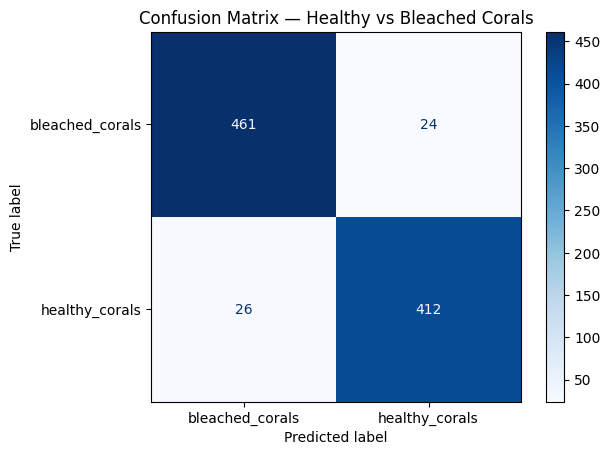

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_dataset.classes)

plt.figure(figsize=(7,7))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Healthy vs Bleached Corals")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [18]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))



Classification Report:

                 precision    recall  f1-score   support

bleached_corals       0.95      0.95      0.95       485
 healthy_corals       0.94      0.94      0.94       438

       accuracy                           0.95       923
      macro avg       0.95      0.95      0.95       923
   weighted avg       0.95      0.95      0.95       923



In [15]:
def generate_gradcam(img_path):
    img = Image.open(img_path).convert("RGB")

    input_tensor = test_transform(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_class = output.argmax().item()

    cam = cam_extractor(pred_class, output)[0].cpu().detach().numpy()
    cam = cv2.resize(cam, (img.size[0], img.size[1]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

    img_np = np.array(img)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(heatmap, 0.6, img_np, 0.4, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    return img, overlay


In [12]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        def save_gradient(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def save_activation(module, input, output):
            self.activations = output

        layer = dict([*self.model.named_modules()])[target_layer]
        layer.register_forward_hook(save_activation)
        layer.register_backward_hook(save_gradient)

    def __call__(self, class_idx, preds):
        self.model.zero_grad()
        preds[:, class_idx].backward(retain_graph=True)

        grads = self.gradients
        activs = self.activations

        weights = grads.mean(dim=[2, 3], keepdim=True)
        cam = (weights * activs).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam

# Initialize Grad-CAM
cam_extractor = GradCAM(model, target_layer="backbone.layer4")
print("GradCAM ready.")


GradCAM ready.


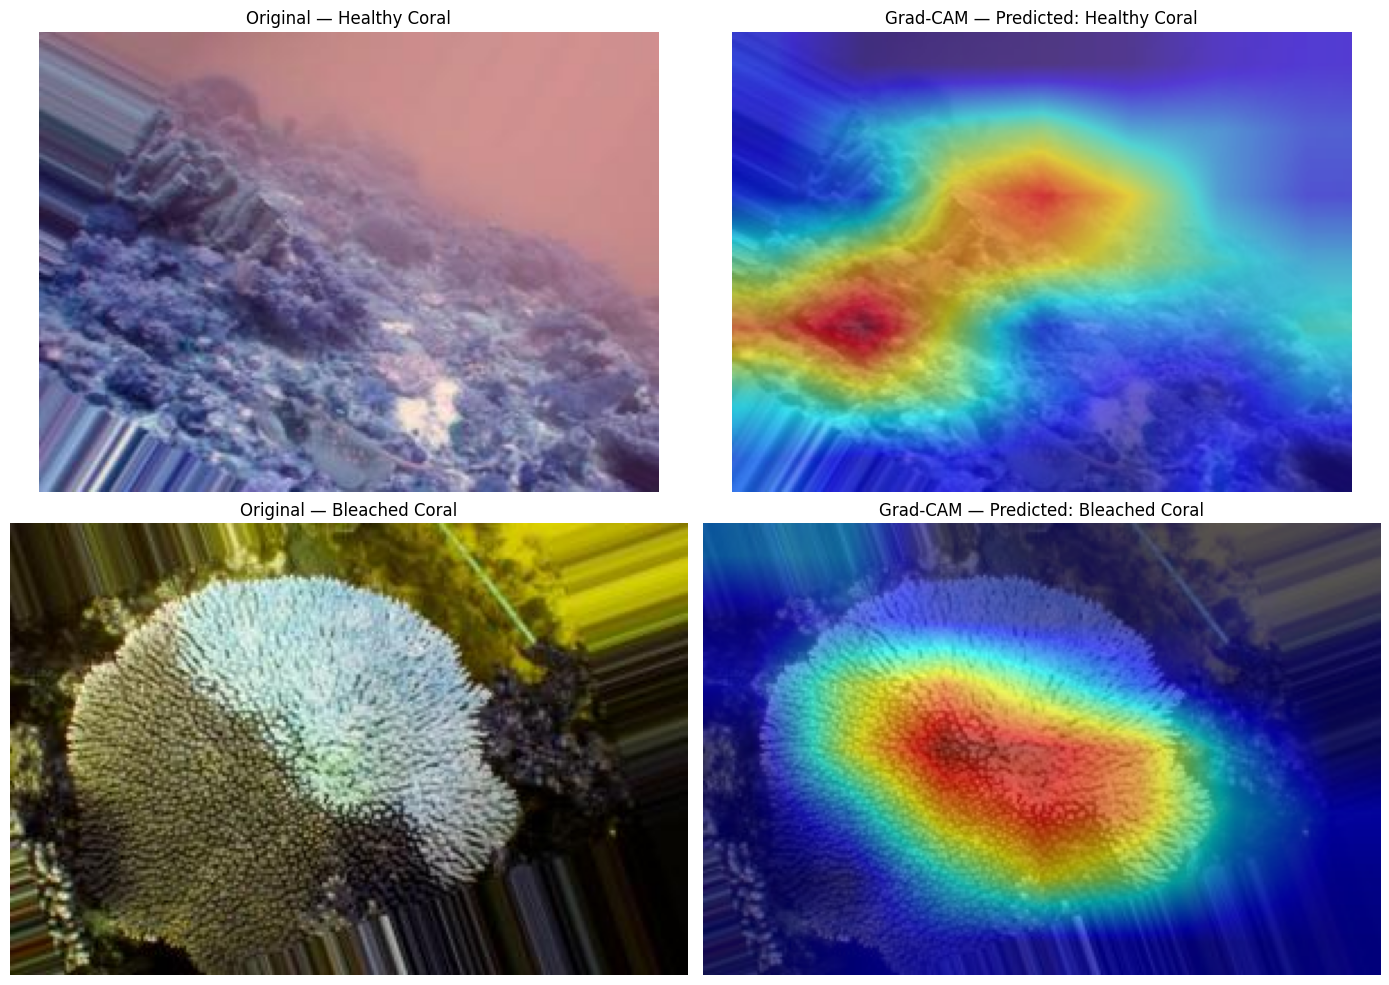

In [20]:
import random

healthy_dir = os.path.join(test_dir, "healthy_corals")
bleached_dir = os.path.join(test_dir, "bleached_corals")

healthy_img_path = os.path.join(healthy_dir, random.choice(os.listdir(healthy_dir)))
bleached_img_path = os.path.join(bleached_dir, random.choice(os.listdir(bleached_dir)))

healthy_original, healthy_grad = generate_gradcam(healthy_img_path)
bleached_original, bleached_grad = generate_gradcam(bleached_img_path)

plt.figure(figsize=(14, 10))

# Healthy Coral
plt.subplot(2, 2, 1)
plt.imshow(healthy_original)
plt.title("Original — Healthy Coral")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(healthy_grad)
plt.title("Grad-CAM — Predicted: Healthy Coral")
plt.axis("off")

# Bleached Coral
plt.subplot(2, 2, 3)
plt.imshow(bleached_original)
plt.title("Original — Bleached Coral")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(bleached_grad)
plt.title("Grad-CAM — Predicted: Bleached Coral")
plt.axis("off")

plt.tight_layout()
plt.show()
